# Модульная архитектура

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from collections import defaultdict, Counter
import random
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount("/gdrive")
# save_dir = "/gdrive/MyDrive/ds/data/saved_models"
save_dir = "./data"
save_models_dir = "./data/saved_models"

## Определение Моделей
### Autoencoder

In [3]:
import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(Autoencoder, self).__init__()
        # Энкодер с увеличенной емкостью и InstanceNorm2d
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(128),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(128),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(256),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(256),
            nn.MaxPool2d(2),  # 8x8
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(512),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(512),
            nn.MaxPool2d(2),  # 4x4
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(512),
            nn.MaxPool2d(2),  # 2x2
        )

        self.fc_enc = nn.Linear(512 * 2 * 2, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 512 * 2 * 2)

        # Декодер с увеличенной емкостью и InstanceNorm2d
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(512),
            nn.ConvTranspose2d(512, 512, 4, 2, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(512),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.InstanceNorm2d(128),
            nn.Conv2d(128, 3, 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)  # [B,512,2,2]
        B = z.size(0)
        z = z.view(B, -1)
        z_latent = self.fc_enc(z)

        h = self.fc_dec(z_latent)
        h = h.view(B, 512, 2, 2)
        x_recon = self.decoder(h)
        return x_recon, z_latent

    def encode(self, x, require_grad=True):
        if not require_grad:
            with torch.no_grad():
                z = self.encoder(x)
                B = z.size(0)
                z = z.view(B, -1)
                z_latent = self.fc_enc(z)
        else:
            z = self.encoder(x)
            B = z.size(0)
            z = z.view(B, -1)
            z_latent = self.fc_enc(z)
        return z_latent

### BinaryClassifier

In [4]:
class BinaryClassifier(nn.Module):
    def __init__(self, embedding_dim=1024):
        super(BinaryClassifier, self).__init__()
        self.fc = nn.Sequential(nn.Linear(embedding_dim, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 1))

    def forward(self, z):
        out = self.fc(z)
        return out  # Без активации, т.к. используем BCEWithLogitsLoss

 ### 1.3. CombinedBinaryClassifier

In [5]:
class CombinedBinaryClassifier(nn.Module):
    def __init__(self, binary_classifiers, num_classes):
        super(CombinedBinaryClassifier, self).__init__()
        self.binary_classifiers = nn.ModuleList(binary_classifiers)
        self.num_classes = num_classes

    def forward(self, z):
        logits = []
        for classifier in self.binary_classifiers:
            out = classifier(z)
            logits.append(out)
        logits = torch.cat(logits, dim=1)  # [batch, num_classes]
        return logits  # Без активации, будем применять sigmoid позже

### 1.4. Определение Класса MulticlassClassifier

## 2. Определение Класса Trainer
 Класс Trainer будет управлять процессами обучения автокодировщика, бинарных классификаторов, объединённой модели и дообучения энкодера.

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from collections import defaultdict, Counter
import random
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots


class Trainer:
    def __init__(self, num_classes=10, latent_dim=512, batch_size=128, device="cuda" if torch.cuda.is_available() else "cpu", save_dir=save_dir, save_models_dir=save_models_dir):
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.device = device
        self.save_dir = save_dir
        self.save_models_dir = save_models_dir
        os.makedirs(self.save_models_dir, exist_ok=True)

        # Инициализация моделей
        self.autoencoder = Autoencoder(latent_dim=self.latent_dim).to(self.device)
        self.binary_classifiers = [BinaryClassifier(embedding_dim=self.latent_dim).to(self.device) for _ in range(self.num_classes)]
        self.combined_model = CombinedBinaryClassifier(self.binary_classifiers, self.num_classes).to(self.device)

        # Потери и точности
        self.ae_loss_log = []
        self.binary_loss_logs = defaultdict(list)
        self.binary_acc_logs = defaultdict(list)
        self.fine_tune_loss_log = []
        self.fine_tune_acc_log = []

        # Точности до и после финетюнинга
        self.acc_combined_before = 0.0
        self.error_rate_before = 1.0
        self.acc_combined_after = 0.0
        self.error_rate_after = 1.0

    def prepare_dataloaders(self, train_subset, test_subset):
        self.train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        self.test_loader = DataLoader(test_subset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)


def train_autoencoder(self, epochs=10, lr=0.001, suffix="autoenc"):
    """
    Обучение автокодировщика с возможностью возобновления.
    suffix: суффикс для имени файла сохранения, например "autoenc".
    """

    # 1. Проверяем, нет ли уже сохранённой модели и логов по автокодировщику
    saved_ae_path = os.path.join(self.save_models_dir, f"autoencoder_{suffix}.pth")
    log_ae_path = os.path.join(self.save_models_dir, f"autoencoder_{suffix}_log.txt")

    start_epoch = 0
    if os.path.isfile(saved_ae_path):
        print(f"Найдена сохранённая модель автокодировщика: {saved_ae_path}")
        # Загружаем веса
        self.autoencoder.load_state_dict(torch.load(saved_ae_path, map_location=self.device))
        self.autoencoder.to(self.device)
        # Считаем, сколько эпох уже было обучено
        if os.path.isfile(log_ae_path):
            with open(log_ae_path, "r") as f:
                lines = f.readlines()
                if lines:
                    # Предположим, что в последней строке хранится 'last_epoch = X'
                    last_line = lines[-1].strip()
                    if last_line.startswith("last_epoch"):
                        start_epoch = int(last_line.split("=")[-1])
        print(f"Возобновляем обучение с {start_epoch}-й эпохи.")

    # 2. Инициализация оптимизатора и лосса
    optimizer_ae = optim.Adam(self.autoencoder.parameters(), lr=lr)
    criterion_ae = nn.L1Loss()

    # 3. Основной цикл обучения
    for ep in range(start_epoch, epochs):
        epoch_start = time.time()
        self.autoencoder.train()
        running_loss = 0.0

        for d, _ in self.train_loader:
            d = d.to(self.device)
            optimizer_ae.zero_grad()
            x_recon, z = self.autoencoder(d)
            loss = criterion_ae(x_recon, d)
            loss.backward()
            optimizer_ae.step()
            running_loss += loss.item() * d.size(0)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        self.ae_loss_log.append(epoch_loss)
        epoch_end = time.time()

        print(f"Эпоха {ep+1}/{epochs}, Потери AE: {epoch_loss:.6f}, Время: {epoch_end - epoch_start:.2f} сек.")

        # 4. Сохраняем весы и логи по окончании каждой эпохи
        torch.save(self.autoencoder.state_dict(), saved_ae_path)
        with open(log_ae_path, "a") as f:
            f.write(f"epoch={ep+1}, loss={epoch_loss:.6f}, lr={lr}, last_epoch={ep+1}\n")

    def save_models(self, suffix="before_finetune"):
        print("\nСохранение моделей...")
        autoenc_save_path = os.path.join(self.save_models_dir, f"autoencoder_{suffix}.pth")

    def load_autoencoder(self, suffix="before_finetune"):
        """
        Загружает веса автокодировщика из указанного пути.
        Предполагается, что пути уже существуют и содержат корректный .pth файл.
        """
        print(f"\nЗагрузка автокодировщика {suffix} ...")
        autoenc_save_path = os.path.join(self.save_models_dir, f"autoencoder_{suffix}.pth")
        print(f"autoenc_save_path{autoenc_save_path}")
        checkpoint = torch.load(autoenc_save_path, map_location=self.device)
        self.autoencoder.load_state_dict(checkpoint)
        self.autoencoder.to(self.device)
        self.autoencoder.eval()
        print("Автокодировщик успешно загружен.")


def train_binary_classifiers(self, epochs=10, lr=0.001, suffix="bincls"):
    print("\nОбучение бинарных классификаторов для каждого класса...")
    criterion_cls = nn.BCEWithLogitsLoss()

    for cls in range(self.num_classes):
        print(f"\nОбучение классификатора для класса {cls} vs все остальные")

        # Формируем датасет
        pos_samples = [i for i, (_, target) in enumerate(train_subset) if target == cls]
        neg_samples = random.sample([i for i, (_, target) in enumerate(train_subset) if target != cls], len(pos_samples))
        binary_indices = pos_samples + neg_samples
        binary_data = torch.stack([train_subset[i][0] for i in binary_indices], dim=0)
        binary_targets = torch.cat([torch.ones(len(pos_samples)), torch.zeros(len(neg_samples))], dim=0).float()
        binary_dataset = TensorDataset(binary_data, binary_targets)
        binary_loader = DataLoader(binary_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

        # Путь к файлу сохранения и логу
        cls_save_path = os.path.join(self.save_models_dir, f"binary_classifier_class_{cls}_{suffix}.pth")
        cls_log_path = os.path.join(self.save_models_dir, f"binary_classifier_class_{cls}_{suffix}_log.txt")

        start_epoch = 0
        # Если файл существует, загружаем модель и логи
        if os.path.isfile(cls_save_path):
            print(f"Найдены сохранённые веса для классификатора {cls}: {cls_save_path}")
            self.binary_classifiers[cls].load_state_dict(torch.load(cls_save_path, map_location=self.device))
            self.binary_classifiers[cls].to(self.device)

            if os.path.isfile(cls_log_path):
                with open(cls_log_path, "r") as f:
                    lines = f.readlines()
                    if lines:
                        last_line = lines[-1].strip()
                        if last_line.startswith("last_epoch"):
                            start_epoch = int(last_line.split("=")[-1])
            print(f"Возобновляем обучение классификатора {cls} с эпохи {start_epoch}.")

        optimizer_cls = optim.Adam(self.binary_classifiers[cls].parameters(), lr=lr)

        # Запуск обучения на нужное число эпох, начиная с start_epoch
        for ep in range(start_epoch, epochs):
            loss, acc = self._train_binary_classifier(self.binary_classifiers[cls], optimizer_cls, criterion_cls, binary_loader)
            self.binary_loss_logs[cls].append(loss)
            self.binary_acc_logs[cls].append(acc)
            print(f"Class {cls}, Epoch {ep+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {acc*100:.2f}%")

            # Сохраняем модель и лог
            torch.save(self.binary_classifiers[cls].state_dict(), cls_save_path)
            with open(cls_log_path, "a") as f:
                f.write(f"epoch={ep+1}, loss={loss:.4f}, acc={acc:.4f}, lr={lr}, last_epoch={ep+1}\n")

        print(f"Классификатор {cls} - обучение завершено.")

    def _train_binary_classifier(self, model, optimizer, criterion, loader):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data, target in loader:
            data, target = data.to(self.device), target.to(self.device).unsqueeze(1).float()
            optimizer.zero_grad()
            z = self.autoencoder.encode(data)
            outputs = model(z)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)

            preds = torch.sigmoid(outputs) >= 0.5
            correct += (preds.float() == target).sum().item()
            total += target.size(0)
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc

    def evaluate_combined_model(self, loader):
        self.combined_model.eval()
        self.autoencoder.eval()
        correct = 0
        total = 0
        pred_all = []
        target_all = []
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(self.device), target.to(self.device)
                z = self.autoencoder.encode(data)
                logits = self.combined_model(z)  # [batch, num_classes]
                probs = torch.sigmoid(logits)
                preds = torch.argmax(probs, dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)
                pred_all.append(preds.cpu())
                target_all.append(target.cpu())
        if total > 0:
            pred_all = torch.cat(pred_all)
            target_all = torch.cat(target_all)
            accuracy = correct / total
            error_rate = 1 - accuracy
            print(f"Combined model accuracy on all classes (0-{self.num_classes-1}): {accuracy*100:.2f}%")
            print(f"Error rate: {error_rate*100:.2f}%")
            return accuracy, error_rate, pred_all, target_all
        else:
            return 0.0, 1.0, None, None

    def accuracy_per_class(self, pred_all, target_all):
        print("\nAccuracy per class:")
        class_correct = [0] * self.num_classes
        class_total = [0] * self.num_classes
        for p, t in zip(pred_all, target_all):
            class_total[t.item()] += 1
            if p.item() == t.item():
                class_correct[t.item()] += 1
        for cls in range(self.num_classes):
            if class_total[cls] > 0:
                acc = class_correct[cls] / class_total[cls] * 100
                print(f"Class {cls}: {acc:.2f}%")
            else:
                print(f"Class {cls}: No samples in test set.")

    def save_models(self, suffix="before_finetune"):
        print("\nСохранение моделей...")
        autoenc_save_path = os.path.join(self.save_models_dir, f"autoencoder_{suffix}.pth")
        torch.save(self.autoencoder.state_dict(), autoenc_save_path)
        print(f"Autoencoder сохранён по пути: {autoenc_save_path}")

        combined_model_save_path = os.path.join(self.save_models_dir, f"combined_model_{suffix}.pth")
        torch.save(self.combined_model.state_dict(), combined_model_save_path)
        print(f"CombinedBinaryClassifier сохранён по пути: {combined_model_save_path}")

        # Сохранение бинарных классификаторов отдельно
        for cls in range(self.num_classes):
            classifier_save_path = os.path.join(self.save_models_dir, f"binary_classifier_class_{cls}_{suffix}.pth")
            torch.save(self.binary_classifiers[cls].state_dict(), classifier_save_path)
            print(f"BinaryClassifier {cls} сохранён по пути: {classifier_save_path}")

    def load_models(self, suffix="before_finetune", model_type=""):
        """model_type = autoenc|combined_model|classifier"""
        print("\nЗагрузка моделей...")
        if model_type == "" or model_type == "autoenc":
            autoenc_save_path = os.path.join(self.save_models_dir, f"autoencoder_{suffix}.pth")
            self.autoencoder.load_state_dict(torch.load(autoenc_save_path))
            self.autoencoder.to(self.device)
            print(f"Autoencoder загружен из {autoenc_save_path}")
        if model_type == "" or model_type == "combined_model":
            combined_model_save_path = os.path.join(self.save_models_dir, f"combined_model_{suffix}.pth")
            self.combined_model.load_state_dict(torch.load(combined_model_save_path))
            self.combined_model.to(self.device)
            print(f"CombinedBinaryClassifier загружен из {combined_model_save_path}")
        if model_type == "" or model_type == "classifier":
            # Загрузка бинарных классификаторов отдельно
            for cls in range(self.num_classes):
                classifier_save_path = os.path.join(self.save_models_dir, f"binary_classifier_class_{cls}_{suffix}.pth")
                self.binary_classifiers[cls].load_state_dict(torch.load(classifier_save_path))
                self.binary_classifiers[cls].to(self.device)
                print(f"BinaryClassifier {cls} загружен из {classifier_save_path}")

    def fine_tune_encoder(self, fine_tune_loader, epochs=3, lr=0.0005):
        print("\nДообучение энкодера на небольшой выборке с фиксированными классификаторами...")
        criterion_fine = nn.BCEWithLogitsLoss()
        optimizer_enc = optim.Adam([p for p in self.autoencoder.parameters() if p.requires_grad], lr=lr)

        for ep in range(epochs):
            ep_start = time.time()  # Определяем ep_start перед обучением
            loss_fine, acc_fine = self._train_encoder_fixed_classifiers(criterion_fine, fine_tune_loader, optimizer_enc)
            self.fine_tune_loss_log.append(loss_fine)
            self.fine_tune_acc_log.append(acc_fine)
            ep_end = time.time()
            print(f"Fine-tuning Epoch {ep+1}/{epochs}, Loss: {loss_fine:.4f}, Accuracy: {acc_fine*100:.2f}%, Время: {ep_end - ep_start:.2f} сек.")

    def _train_encoder_fixed_classifiers(self, criterion, loader, optimizer):
        self.combined_model.eval()  # Классификаторы фиксированы
        self.autoencoder.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data, target in loader:
            data, target = data.to(self.device), target.to(self.device).long()
            batch_size = data.size(0)
            optimizer.zero_grad()
            z = self.autoencoder.encode(data, require_grad=True)  # Позволяем градиентам проходить

            # Получаем логиты из всех классификаторов
            logits_all = []
            for cls in range(self.num_classes):
                classifier = self.combined_model.binary_classifiers[cls]
                logit = classifier(z)  # [batch_size,1]
                logits_all.append(logit)
            logits_all = torch.cat(logits_all, dim=1)  # [batch_size, num_classes]

            # Создаём целевые метки: 1 для правильного класса, 0 для остальных
            targets = torch.zeros(batch_size, self.num_classes).to(self.device)
            targets[torch.arange(batch_size), target] = 1.0

            # Вычисляем loss
            loss = criterion(logits_all, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_size

            # Предсказания: sigmoid and argmax
            preds = torch.sigmoid(logits_all)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == target).sum().item()
            total += batch_size
        avg_loss = running_loss / total
        accuracy = correct / total
        return avg_loss, accuracy

    def plot_results(self):
        print("\nГрафическое отображение результатов...")

        # Усреднение потерь и точности по всем бинарным классификаторам
        mean_binary_loss_per_epoch = [sum(vals) / len(vals) for vals in zip(*self.binary_loss_logs.values())]
        mean_binary_acc_per_epoch = [sum(vals) / len(vals) for vals in zip(*self.binary_acc_logs.values())]

        fig = make_subplots(
            rows=2,
            cols=2,
            subplot_titles=(
                "Потери Автокодировщика",
                "Потери и Точность Бинарных Классификаторов (среднее по всем классам)",
                "Потери и Точность Дообучения Энкодера",
                "Итоговая Точность Модели",
            ),
        )

        # Потери Автокодировщика
        fig.add_trace(go.Scatter(y=self.ae_loss_log, mode="lines+markers", name="AE Loss"), row=1, col=1)

        # Средние потери и точность бинарных классификаторов
        fig.add_trace(go.Scatter(y=mean_binary_loss_per_epoch, mode="lines+markers", name="Binary Cls Mean Loss"), row=1, col=2)
        fig.add_trace(go.Scatter(y=mean_binary_acc_per_epoch, mode="lines+markers", name="Binary Cls Mean Acc"), row=1, col=2)

        # Потери и точность Дообучения Энкодера
        fig.add_trace(go.Scatter(y=self.fine_tune_loss_log, mode="lines+markers", name="Fine-tune Loss"), row=2, col=1)
        fig.add_trace(go.Scatter(y=self.fine_tune_acc_log, mode="lines+markers", name="Fine-tune Accuracy"), row=2, col=1)

        # Итоговая Точность Модели до и после Дообучения
        fig.add_trace(
            go.Bar(
                x=["Before Fine-tuning", "After Fine-tuning"], y=[self.acc_combined_before, self.acc_combined_after], name="Combined Model Accuracy", marker_color=["blue", "green"]
            ),
            row=2,
            col=2,
        )

        fig.update_layout(height=800, width=1200, title_text="Анализ Обучения", showlegend=True)
        fig.show()

        # Отображение confusion matrix до финетюнинга
        if hasattr(self, "cm_before"):
            fig_cm_before = go.Figure(data=go.Heatmap(z=self.cm_before, x=list(range(self.num_classes)), y=list(range(self.num_classes)), colorscale="Blues"))
            fig_cm_before.update_layout(title="Confusion Matrix Before Fine-tuning", xaxis_title="Predicted", yaxis_title="True")
            fig_cm_before.show()

        # Отображение confusion matrix после финетюнинга
        if hasattr(self, "cm_after"):
            fig_cm_after = go.Figure(data=go.Heatmap(z=self.cm_after, x=list(range(self.num_classes)), y=list(range(self.num_classes)), colorscale="Blues"))
            fig_cm_after.update_layout(title="Confusion Matrix After Fine-tuning", xaxis_title="Predicted", yaxis_title="True")
            fig_cm_after.show()

    def perform_full_cycle(self, train_subset, test_subset, fine_tune_epochs=3, fine_tune_lr=0.0005):
        """
        Выполняет полный цикл:
        1. Обучение автокодировщика
        2. Обучение бинарных классификаторов
        3. Оценка модели
        4. Сохранение моделей перед финетюнингом
        5. Финетюнинг энкодера
        6. Оценка модели после финетюнинга
        7. Сохранение моделей после финетюнинга
        """
        self.prepare_dataloaders(train_subset, test_subset)
        self.train_autoencoder(epochs=epochs, lr=0.001)
        self.train_binary_classifiers(epochs=epochs, lr=0.001)
        self.evaluate_and_log()
        self.save_models(suffix="before_finetune")
        self.fine_tune_encoder_after_cycle(fine_tune_epochs, fine_tune_lr)
        self.evaluate_and_log(after_finetune=True)
        self.save_models(suffix="after_finetune")

    def evaluate_and_log(self, after_finetune=False):
        print("\nОценка объединённой модели...")
        if after_finetune:
            prefix = "После финетюнинга"
        else:
            prefix = "До финетюнинга"
        print(f"{prefix} оценки модели на тестовом наборе:")
        acc, error_rate, pred_all, target_all = self.evaluate_combined_model(self.test_loader)
        self.accuracy_per_class(pred_all, target_all)
        cm = confusion_matrix(target_all, pred_all, labels=list(range(self.num_classes)))
        if after_finetune:
            self.cm_after = cm
        else:
            self.cm_before = cm

    def fine_tune_encoder_after_cycle(self, fine_tune_epochs=3, fine_tune_lr=0.0005):
        # Создаём выборку для дообучения
        fine_tune_subset = create_fine_tuning_subset(train_dataset, self.num_classes, samples_per_class)
        fine_tune_loader = DataLoader(fine_tune_subset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        self.fine_tune_encoder(fine_tune_loader, epochs=fine_tune_epochs, lr=fine_tune_lr)

    def denormalize(self, tensor):
        # Предполагается, что данные были нормализованы так:
        # mean = (0.4914, 0.4822, 0.4465), std = (0.247, 0.243, 0.261)
        mean = torch.tensor([0.4914, 0.4822, 0.4465])
        std = torch.tensor([0.247, 0.243, 0.261])
        # tensor: [C,H,W]
        tensor = tensor * std[:, None, None] + mean[:, None, None]
        return tensor.clamp(0, 1)

    def visualize_reconstruction(self, n=8):
        self.autoencoder.eval()
        # Берём один батч из test_loader
        images, _ = next(iter(self.test_loader))
        images = images.to(self.device)

        with torch.no_grad():
            recon, _ = self.autoencoder(images)

        images = images.cpu()
        recon = recon.cpu()

        fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(2 * n, 4))
        for i in range(n):
            # Исходное изображение
            ax_orig = axes[0, i]
            img_orig = self.denormalize(images[i]).permute(1, 2, 0).detach().numpy()
            ax_orig.imshow(img_orig)
            ax_orig.axis("off")
            if i == 0:
                ax_orig.set_title("Original")

            # Реконструированное изображение
            ax_recon = axes[1, i]
            img_recon = self.denormalize(recon[i]).permute(1, 2, 0).detach().numpy()
            ax_recon.imshow(img_recon)
            ax_recon.axis("off")
            if i == 0:
                ax_recon.set_title("Reconstructed")

        plt.tight_layout()
        plt.show()

## 3. Подготовка Данных
Создадим утилитные функции для подготовки датасетов и загрузчиков.

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict, Counter
import random


def filter_dataset(dataset, num_classes, min_samples):
    """
    Фильтрует датасет, оставляя только `num_classes` классов и минимум `min_samples` образцов на класс.
    """
    class_counts = Counter()
    class_indices = defaultdict(list)

    # Собираем индексы для каждого класса
    for idx, (_, target) in enumerate(dataset):
        if target < num_classes:
            class_indices[target].append(idx)
            class_counts[target] += 1

    # Проверяем, что каждый класс имеет минимум образцов
    """ for cls in range(num_classes):
        if class_counts[cls] < min_samples:
            raise ValueError(f"Класс {cls} имеет только {class_counts[cls]} образцов, требуется минимум {min_samples}.") """

    # Ограничиваем количество образцов до min_samples для каждого класса
    selected_indices = []
    for cls in range(num_classes):
        selected_indices.extend(class_indices[cls][:min_samples])

    return Subset(dataset, selected_indices)

## 4. Основной Скрипт
Теперь объединим всё вместе в основном скрипте, который будет использовать класс Trainer для выполнения всех этапов обучения, сохранения и загрузки моделей.

### 4.1. Ячейка 1: Обучение Автокодировщика и Бинарных Классификаторов, Сохранение Моделей

In [ ]:
""" 
# Этап 1. Включаем только вручную, чтобы не стереть предыдущие данные
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from collections import defaultdict, Counter

# Предполагается, что классы Autoencoder, MulticlassClassifier и Trainer уже определены выше

# Настройки
num_classes = 10
latent_dim = 1024
batch_size = 128
epochs = 50
min_samples_per_class = 5000  # Увеличено до 200
max_test_samples = 400000

# Подготовка трансформаций с аугментацией данных
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

# Загрузка датасетов
train_dataset = datasets.CIFAR10(root=save_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=save_dir, train=False, download=True, transform=transform)

# Фильтрация датасетов
train_subset = filter_dataset(train_dataset, num_classes, min_samples_per_class)
test_subset = filter_dataset(test_dataset, num_classes, min_samples_per_class)

# Ограничение тестового набора
if len(test_subset) > max_test_samples:
    test_indices = random.sample(range(len(test_subset)), max_test_samples)
    test_subset = Subset(test_subset, test_indices)

# Инициализация тренера
trainer = Trainer(num_classes=num_classes, latent_dim=latent_dim, batch_size=batch_size, device="cuda" if torch.cuda.is_available() else "cpu", save_dir=save_dir)

# Подготовка загрузчиков данных
trainer.prepare_dataloaders(train_subset, test_subset)
#########################
# Обучение автокодировщика
# trainer.load_autoencoder()
trainer.train_autoencoder(epochs=int(epochs), lr=0.001)

trainer.visualize_reconstruction()
# Сохранение моделей перед финетюнингом
trainer.save_models(suffix="before_finetune")
"""

' # Этап 1\n\nimport torch\nfrom torchvision import datasets, transforms\nfrom torch.utils.data import DataLoader, Subset\nimport random\nfrom collections import defaultdict, Counter\n\n# Предполагается, что классы Autoencoder, MulticlassClassifier и Trainer уже определены выше\n\n# Настройки\nnum_classes = 10\nlatent_dim = 1024\nbatch_size = 128\nepochs = 50\nmin_samples_per_class = 5000  # Увеличено до 200\nmax_test_samples = 400000\nsave_dir = "/gdrive/MyDrive/ds/data/saved_models"\n\n# Подготовка трансформаций с аугментацией данных\ntransform = transforms.Compose(\n    [\n        transforms.Resize(32),\n        transforms.RandomHorizontalFlip(),\n        transforms.RandomCrop(32, padding=4),\n        transforms.ToTensor(),\n        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),\n    ]\n)\n\n# Загрузка датасетов\ntrain_dataset = datasets.CIFAR10(root="/gdrive/MyDrive/ds/data", train=True, download=True, transform=transform)\ntest_dataset = datasets.CIFAR10(ro

Files already downloaded and verified
Files already downloaded and verified

Загрузка автокодировщика before_finetune ...
autoenc_save_path/gdrive/MyDrive/ds/data/saved_models/autoencoder_before_finetune.pth


<ipython-input-11-6c12f460e2e9>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(autoenc_save_path, map_location=self.device)


Автокодировщик успешно загружен.

Инициализация и обучение автокодировщика...
Эпоха 1/50, Потери AE: 0.760189, Время: 83.53 сек.
Эпоха 2/50, Потери AE: 0.759539, Время: 82.37 сек.
Эпоха 3/50, Потери AE: 0.758920, Время: 82.20 сек.
Эпоха 4/50, Потери AE: 0.758758, Время: 82.09 сек.
Эпоха 5/50, Потери AE: 0.757905, Время: 82.39 сек.
Эпоха 6/50, Потери AE: 0.758866, Время: 82.08 сек.
Эпоха 7/50, Потери AE: 0.756967, Время: 82.26 сек.
Эпоха 8/50, Потери AE: 0.757187, Время: 82.06 сек.
Эпоха 9/50, Потери AE: 0.757700, Время: 82.08 сек.
Эпоха 10/50, Потери AE: 0.756898, Время: 82.15 сек.
Эпоха 11/50, Потери AE: 0.757204, Время: 82.21 сек.
Эпоха 12/50, Потери AE: 0.756263, Время: 82.20 сек.
Эпоха 13/50, Потери AE: 0.756357, Время: 82.21 сек.
Эпоха 14/50, Потери AE: 0.756046, Время: 82.21 сек.
Эпоха 15/50, Потери AE: 0.756357, Время: 82.21 сек.
Эпоха 16/50, Потери AE: 0.755623, Время: 82.23 сек.
Эпоха 17/50, Потери AE: 0.755186, Время: 82.15 сек.
Эпоха 18/50, Потери AE: 0.754584, Время: 82.33 

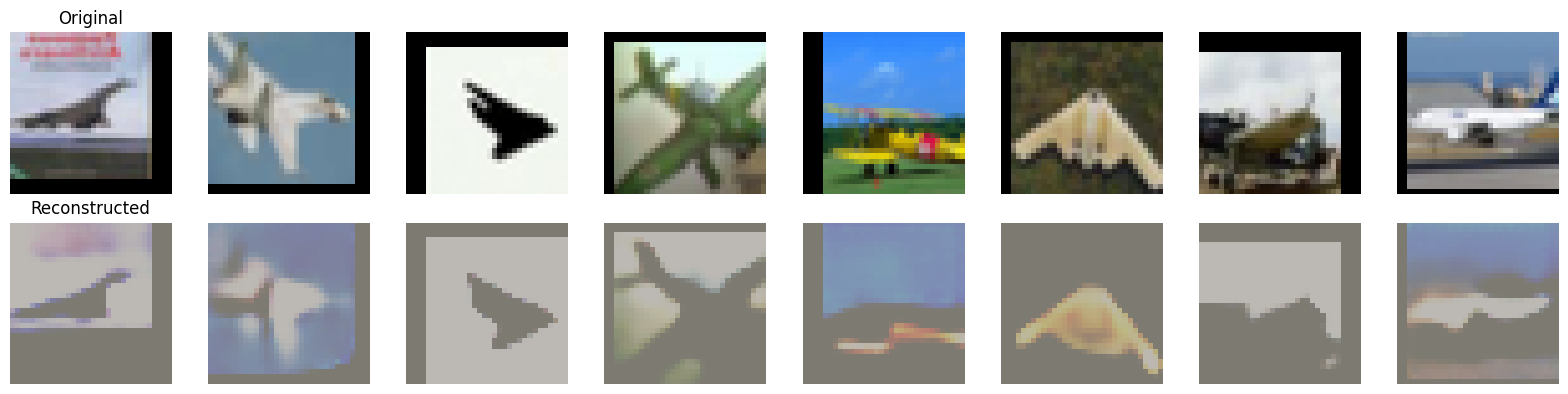


Сохранение моделей...
Autoencoder сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/autoencoder_before_finetune.pth
CombinedBinaryClassifier сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/combined_model_before_finetune.pth
BinaryClassifier 0 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_0_before_finetune.pth
BinaryClassifier 1 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_1_before_finetune.pth
BinaryClassifier 2 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_2_before_finetune.pth
BinaryClassifier 3 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_3_before_finetune.pth
BinaryClassifier 4 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_4_before_finetune.pth
BinaryClassifier 5 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_5_before_finetune.pth
BinaryClassifier 6 сохранён по пути: /gdriv

In [ ]:
# Этап 2
# Настройки
num_classes = 10
latent_dim = 1024
batch_size = 128
epochs = 50
min_samples_per_class = 5000  # Увеличено до 200
max_test_samples = 400000
iterations = 3

for step in range(iterations - 1):
    # Подготовка трансформаций с аугментацией данных
    transform = transforms.Compose(
        [
            transforms.Resize(32),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )

    # Загрузка датасетов
    train_dataset = datasets.CIFAR10(root=save_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=save_dir, train=False, download=True, transform=transform)

    # Фильтрация датасетов
    train_subset = filter_dataset(train_dataset, num_classes, min_samples_per_class)
    test_subset = filter_dataset(test_dataset, num_classes, min_samples_per_class)

    # Ограничение тестового набора
    if len(test_subset) > max_test_samples:
        test_indices = random.sample(range(len(test_subset)), max_test_samples)
        test_subset = Subset(test_subset, test_indices)

    # Инициализация тренера
    trainer = Trainer(num_classes=num_classes, latent_dim=latent_dim, batch_size=batch_size, device="cuda" if torch.cuda.is_available() else "cpu", save_dir=save_dir)

    # Подготовка загрузчиков данных
    trainer.prepare_dataloaders(train_subset, test_subset)
    #########################
    # Обучение автокодировщика
    trainer.load_autoencoder()
    trainer.train_autoencoder(epochs=int(epochs), lr=0.001)

    trainer.visualize_reconstruction()
    # Сохранение моделей перед финетюнингом
    trainer.save_models(suffix="before_finetune")

Files already downloaded and verified
Files already downloaded and verified

Загрузка автокодировщика before_finetune ...
autoenc_save_path/gdrive/MyDrive/ds/data/saved_models/autoencoder_before_finetune.pth


<ipython-input-5-6c12f460e2e9>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(autoenc_save_path, map_location=self.device)


Автокодировщик успешно загружен.


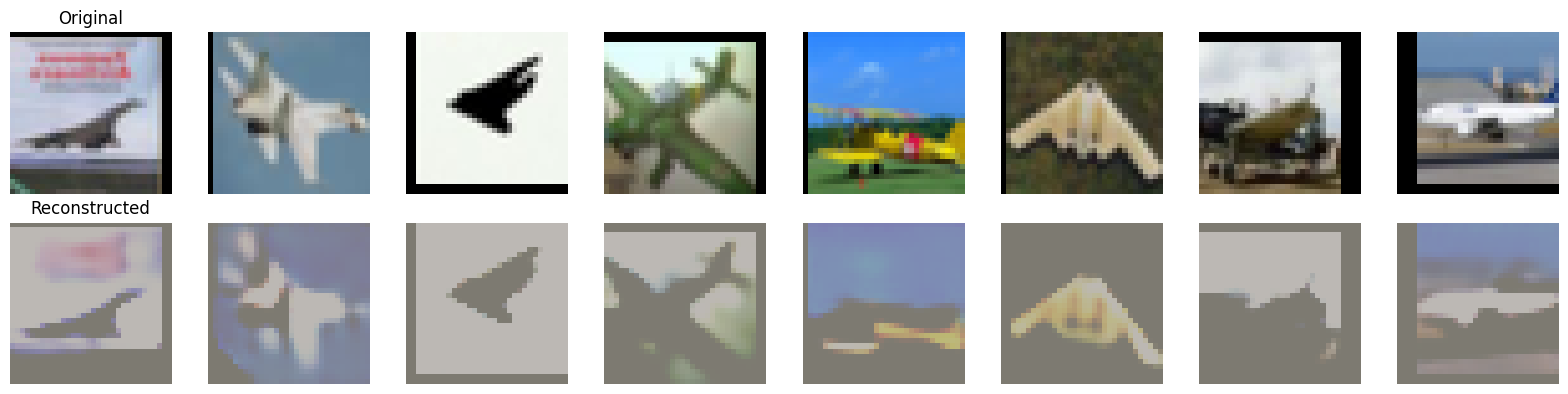


Сохранение моделей...
Autoencoder сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/autoencoder_before_finetune.pth
CombinedBinaryClassifier сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/combined_model_before_finetune.pth
BinaryClassifier 0 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_0_before_finetune.pth
BinaryClassifier 1 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_1_before_finetune.pth
BinaryClassifier 2 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_2_before_finetune.pth
BinaryClassifier 3 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_3_before_finetune.pth
BinaryClassifier 4 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_4_before_finetune.pth
BinaryClassifier 5 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_5_before_finetune.pth
BinaryClassifier 6 сохранён по пути: /gdriv

In [ ]:
# %%

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from collections import defaultdict, Counter

# Предполагается, что классы Autoencoder, MulticlassClassifier и Trainer уже определены выше

# Настройки
num_classes = 10
latent_dim = 1024
batch_size = 128
epochs = 100
min_samples_per_class = 5000  # Увеличено до 200
max_test_samples = 400000

# Подготовка трансформаций с аугментацией данных
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

# Загрузка датасетов
train_dataset = datasets.CIFAR10(root=save_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=save_dir, train=False, download=True, transform=transform)

# Фильтрация датасетов
train_subset = filter_dataset(train_dataset, num_classes, min_samples_per_class)
test_subset = filter_dataset(test_dataset, num_classes, min_samples_per_class)

# Ограничение тестового набора
if len(test_subset) > max_test_samples:
    test_indices = random.sample(range(len(test_subset)), max_test_samples)
    test_subset = Subset(test_subset, test_indices)

# Инициализация тренера
trainer = Trainer(num_classes=num_classes, latent_dim=latent_dim, batch_size=batch_size, device="cuda" if torch.cuda.is_available() else "cpu", save_dir=save_dir)

# Подготовка загрузчиков данных
trainer.prepare_dataloaders(train_subset, test_subset)

# Обучение многоклассового классификатора
trainer.train_binary_classifiers(epochs=int(epochs), lr=0.001)

# Оценка модели до финетюнинга
trainer.acc_combined_before, trainer.error_rate_before, trainer.pred_all_before, trainer.target_all_before = trainer.evaluate_combined_model(trainer.test_loader)

# Подсчёт точности по каждому классу до финетюнинга
trainer.accuracy_per_class(trainer.pred_all_before, trainer.target_all_before)

# Сохранение моделей перед финетюнингом
trainer.save_models(suffix="before_finetune")

### 4.2. Ячейка 2: Загрузка Моделей и Дообучение Энкодера

In [ ]:
# %%

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from collections import defaultdict, Counter

# Определите классы Autoencoder, BinaryClassifier, CombinedBinaryClassifier и Trainer здесь или импортируйте из другого файла

# Настройки
num_classes = 10
latent_dim = 1024
batch_size = 64  # Изменено пользователем
fine_tuning_epochs = 50  # Изменено пользователем
samples_per_class = 5000
save_dir = "/gdrive/MyDrive/ds/data/saved_models"

# Инициализация тренера
trainer = Trainer(num_classes=num_classes, latent_dim=latent_dim, batch_size=batch_size, device="cuda" if torch.cuda.is_available() else "cpu", save_dir=save_dir)

# Определение трансформаций
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

# Загрузка датасета для дообучения
train_dataset = datasets.CIFAR10(root=save_dir, train=True, download=True, transform=transform)


def create_fine_tuning_subset(dataset, num_classes, samples_per_class=100):
    selected_indices = []
    class_counts = Counter()
    class_indices = defaultdict(list)

    for idx, (_, target) in enumerate(dataset):
        if target < num_classes and class_counts[target] < samples_per_class:
            class_indices[target].append(idx)
            class_counts[target] += 1
            selected_indices.append(idx)
        if all(count >= samples_per_class for count in class_counts.values()):
            break

    return Subset(dataset, selected_indices)


def filter_dataset(dataset, num_classes, min_samples):
    """
    Фильтрует датасет, оставляя только `num_classes` классов и минимум `min_samples` образцов на класс.
    """
    class_counts = Counter()
    class_indices = defaultdict(list)

    # Собираем индексы для каждого класса
    for idx, (_, target) in enumerate(dataset):
        if target < num_classes:
            class_indices[target].append(idx)
            class_counts[target] += 1

    # Проверяем, что каждый класс имеет минимум образцов
    for cls in range(num_classes):
        if class_counts[cls] < min_samples:
            raise ValueError(f"Класс {cls} имеет только {class_counts[cls]} образцов, требуется минимум {min_samples}.")

    # Ограничиваем количество образцов до min_samples для каждого класса
    selected_indices = []
    for cls in range(num_classes):
        selected_indices.extend(class_indices[cls][:min_samples])

    return Subset(dataset, selected_indices)


# Создание выборки для дообучения
fine_tune_subset = create_fine_tuning_subset(train_dataset, num_classes, samples_per_class)
fine_tune_loader = DataLoader(fine_tune_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Загрузка сохранённых моделей
trainer.load_models(suffix="before_finetune")

# Загрузка и фильтрация тестового датасета
test_dataset = datasets.CIFAR10(root=save_dir, train=False, download=True, transform=transform)
test_subset = filter_dataset(test_dataset, num_classes, min_samples=1000)  # Используем тот же min_samples_per_class

# Подготовка загрузчиков данных (инициализирует test_loader)
trainer.prepare_dataloaders(fine_tune_subset, test_subset)

# Дообучение энкодера
trainer.fine_tune_encoder(fine_tune_loader, epochs=fine_tuning_epochs, lr=0.0005, suffix="before_finetune")

# Оценка объединённой модели после дообучения
trainer.acc_combined_after, trainer.error_rate_after, pred_all_after, target_all_after = trainer.evaluate_combined_model(trainer.test_loader)

# Подсчёт точности по каждому классу
trainer.accuracy_per_class(pred_all_after, target_all_after)

# Сохранение моделей после дообучения
trainer.save_models(suffix="after_finetune")

trainer.plot_results()

In [ ]:
# Посмотрим как улучшатся классификаторы на тюнингованном энкодере

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from collections import defaultdict, Counter

# Предполагается, что классы Autoencoder, MulticlassClassifier и Trainer уже определены выше

# Настройки
num_classes = 10
latent_dim = 1024
batch_size = 128
epochs = 100
min_samples_per_class = 5000  # Увеличено до 200
max_test_samples = 400000

# Подготовка трансформаций с аугментацией данных
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

# Загрузка датасетов
train_dataset = datasets.CIFAR10(root=save_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=save_dir, train=False, download=True, transform=transform)

# Фильтрация датасетов
train_subset = filter_dataset(train_dataset, num_classes, min_samples_per_class)
test_subset = filter_dataset(test_dataset, num_classes, min_samples_per_class)

# Ограничение тестового набора
if len(test_subset) > max_test_samples:
    test_indices = random.sample(range(len(test_subset)), max_test_samples)
    test_subset = Subset(test_subset, test_indices)

# Инициализация тренера
trainer = Trainer(num_classes=num_classes, latent_dim=latent_dim, batch_size=batch_size, device="cuda" if torch.cuda.is_available() else "cpu", save_dir=save_dir)

# Подготовка загрузчиков данных
trainer.prepare_dataloaders(train_subset, test_subset)
#########################
# Загрузка автокодировщика
trainer.load_autoencoder(suffix="after_finetune")

# Обучение многоклассового классификатора
trainer.train_binary_classifiers(epochs=int(epochs), lr=0.001)

# Оценка модели до финетюнинга
trainer.acc_combined_before, trainer.error_rate_before, trainer.pred_all_before, trainer.target_all_before = trainer.evaluate_combined_model(trainer.test_loader)

# Подсчёт точности по каждому классу до финетюнинга
trainer.accuracy_per_class(trainer.pred_all_before, trainer.target_all_before)

# Сохранение моделей перед финетюнингом
trainer.save_models(suffix="classifiers_after_finetune")

# Устарело

Files already downloaded and verified
Files already downloaded and verified

Загрузка автокодировщика before_finetune ...
autoenc_save_path/gdrive/MyDrive/ds/data/saved_models/autoencoder_before_finetune.pth
Автокодировщик успешно загружен.

Инициализация и обучение автокодировщика...


<ipython-input-11-6c12f460e2e9>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(autoenc_save_path, map_location=self.device)


Эпоха 1/50, Потери AE: 0.748804, Время: 82.39 сек.
Эпоха 2/50, Потери AE: 0.749070, Время: 82.20 сек.
Эпоха 3/50, Потери AE: 0.747962, Время: 82.17 сек.
Эпоха 4/50, Потери AE: 0.748692, Время: 82.16 сек.
Эпоха 5/50, Потери AE: 0.748788, Время: 82.10 сек.
Эпоха 6/50, Потери AE: 0.747283, Время: 82.20 сек.
Эпоха 7/50, Потери AE: 0.748492, Время: 82.25 сек.
Эпоха 8/50, Потери AE: 0.747799, Время: 82.04 сек.
Эпоха 9/50, Потери AE: 0.747595, Время: 82.28 сек.
Эпоха 10/50, Потери AE: 0.747415, Время: 82.12 сек.
Эпоха 11/50, Потери AE: 0.747675, Время: 82.34 сек.
Эпоха 12/50, Потери AE: 0.746373, Время: 82.03 сек.
Эпоха 13/50, Потери AE: 0.747088, Время: 82.20 сек.
Эпоха 14/50, Потери AE: 0.746551, Время: 82.31 сек.
Эпоха 15/50, Потери AE: 0.746489, Время: 82.20 сек.
Эпоха 16/50, Потери AE: 0.746310, Время: 82.39 сек.
Эпоха 17/50, Потери AE: 0.747061, Время: 82.11 сек.
Эпоха 18/50, Потери AE: 0.746319, Время: 82.28 сек.
Эпоха 19/50, Потери AE: 0.746058, Время: 82.22 сек.
Эпоха 20/50, Потери A

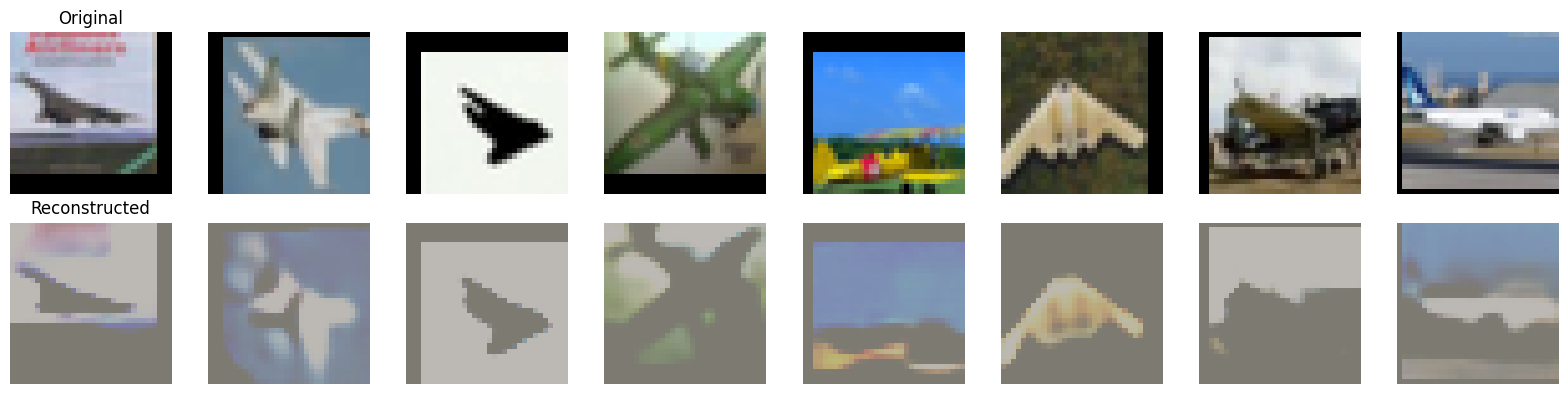


Сохранение моделей...
Autoencoder сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/autoencoder_before_finetune.pth
CombinedBinaryClassifier сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/combined_model_before_finetune.pth
BinaryClassifier 0 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_0_before_finetune.pth
BinaryClassifier 1 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_1_before_finetune.pth
BinaryClassifier 2 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_2_before_finetune.pth
BinaryClassifier 3 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_3_before_finetune.pth
BinaryClassifier 4 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_4_before_finetune.pth
BinaryClassifier 5 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_5_before_finetune.pth
BinaryClassifier 6 сохранён по пути: /gdriv

In [ ]:
""" 
# Этап 3 Устарело.

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from collections import defaultdict, Counter

# Предполагается, что классы Autoencoder, MulticlassClassifier и Trainer уже определены выше

# Настройки
num_classes = 10
latent_dim = 1024
batch_size = 128
epochs = 50
min_samples_per_class = 5000  # Увеличено до 200
max_test_samples = 400000
save_dir = "/gdrive/MyDrive/ds/data/saved_models"

# Подготовка трансформаций с аугментацией данных
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

# Загрузка датасетов
train_dataset = datasets.CIFAR10(root=save_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=save_dir, train=False, download=True, transform=transform)

# Фильтрация датасетов
train_subset = filter_dataset(train_dataset, num_classes, min_samples_per_class)
test_subset = filter_dataset(test_dataset, num_classes, min_samples_per_class)

# Ограничение тестового набора
if len(test_subset) > max_test_samples:
    test_indices = random.sample(range(len(test_subset)), max_test_samples)
    test_subset = Subset(test_subset, test_indices)

# Инициализация тренера
trainer = Trainer(num_classes=num_classes, latent_dim=latent_dim, batch_size=batch_size, device="cuda" if torch.cuda.is_available() else "cpu", save_dir=save_dir)

# Подготовка загрузчиков данных
trainer.prepare_dataloaders(train_subset, test_subset)
#########################
# Обучение автокодировщика
trainer.load_autoencoder()
trainer.train_autoencoder(epochs=int(epochs), lr=0.001)

trainer.visualize_reconstruction()
# Сохранение моделей перед финетюнингом
trainer.save_models(suffix="before_finetune") """

Files already downloaded and verified
Files already downloaded and verified

Загрузка автокодировщика before_finetune ...
autoenc_save_path/gdrive/MyDrive/ds/data/saved_models/autoencoder_before_finetune.pth
Автокодировщик успешно загружен.

Инициализация и обучение автокодировщика...


<ipython-input-11-6c12f460e2e9>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(autoenc_save_path, map_location=self.device)


Эпоха 1/50, Потери AE: 0.742928, Время: 82.46 сек.
Эпоха 2/50, Потери AE: 0.743537, Время: 82.14 сек.
Эпоха 3/50, Потери AE: 0.743413, Время: 82.27 сек.
Эпоха 4/50, Потери AE: 0.743182, Время: 82.46 сек.
Эпоха 5/50, Потери AE: 0.743218, Время: 82.20 сек.
Эпоха 6/50, Потери AE: 0.742523, Время: 82.38 сек.
Эпоха 7/50, Потери AE: 0.742533, Время: 82.23 сек.
Эпоха 8/50, Потери AE: 0.743073, Время: 82.25 сек.
Эпоха 9/50, Потери AE: 0.742404, Время: 82.21 сек.
Эпоха 10/50, Потери AE: 0.742112, Время: 82.25 сек.
Эпоха 11/50, Потери AE: 0.742154, Время: 82.14 сек.
Эпоха 12/50, Потери AE: 0.741330, Время: 82.20 сек.
Эпоха 13/50, Потери AE: 0.741946, Время: 82.27 сек.
Эпоха 14/50, Потери AE: 0.741785, Время: 82.13 сек.
Эпоха 15/50, Потери AE: 0.741922, Время: 82.22 сек.
Эпоха 16/50, Потери AE: 0.742242, Время: 82.21 сек.
Эпоха 17/50, Потери AE: 0.742176, Время: 82.32 сек.
Эпоха 18/50, Потери AE: 0.742267, Время: 82.11 сек.
Эпоха 19/50, Потери AE: 0.741962, Время: 82.41 сек.
Эпоха 20/50, Потери A

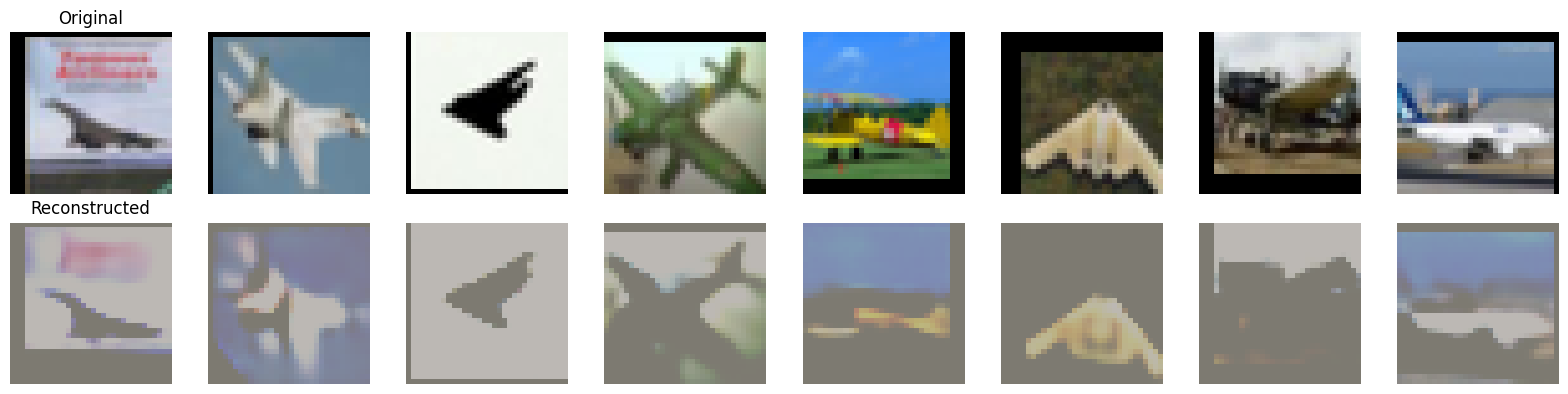


Сохранение моделей...
Autoencoder сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/autoencoder_before_finetune.pth
CombinedBinaryClassifier сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/combined_model_before_finetune.pth
BinaryClassifier 0 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_0_before_finetune.pth
BinaryClassifier 1 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_1_before_finetune.pth
BinaryClassifier 2 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_2_before_finetune.pth
BinaryClassifier 3 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_3_before_finetune.pth
BinaryClassifier 4 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_4_before_finetune.pth
BinaryClassifier 5 сохранён по пути: /gdrive/MyDrive/ds/data/saved_models/binary_classifier_class_5_before_finetune.pth
BinaryClassifier 6 сохранён по пути: /gdriv

In [ ]:
""" 
# Этап 4. Устарело






import torch





from torchvision import datasets, transforms





from torch.utils.data import DataLoader, Subset
import random





from collections import defaultdict, Counter






# Предполагается, что классы Autoencoder, MulticlassClassifier и Trainer уже определены выше






# Настройки





num_classes = 10





latent_dim = 1024





batch_size = 128





epochs = 50





min_samples_per_class = 5000  # Увеличено до 200





max_test_samples = 400000









# Подготовка трансформаций с аугментацией данных





transform = transforms.Compose(





    [





        transforms.Resize(32),





        transforms.RandomHorizontalFlip(),





        transforms.RandomCrop(32, padding=4),





        transforms.ToTensor(),





        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),





    ]
)






# Загрузка датасетов





train_dataset = datasets.CIFAR10(root=save_dir, train=True, download=True, transform=transform)





test_dataset = datasets.CIFAR10(root=save_dir, train=False, download=True, transform=transform)






# Фильтрация датасетов





train_subset = filter_dataset(train_dataset, num_classes, min_samples_per_class)





test_subset = filter_dataset(test_dataset, num_classes, min_samples_per_class)






# Ограничение тестового набора





if len(test_subset) > max_test_samples:





    test_indices = random.sample(range(len(test_subset)), max_test_samples)





    test_subset = Subset(test_subset, test_indices)






# Инициализация тренера





trainer = Trainer(num_classes=num_classes, latent_dim=latent_dim, batch_size=batch_size, device="cuda" if torch.cuda.is_available() else "cpu", save_dir=save_dir)






# Подготовка загрузчиков данных





trainer.prepare_dataloaders(train_subset, test_subset)
#########################





# Обучение автокодировщика
trainer.load_autoencoder()





trainer.train_autoencoder(epochs=int(epochs), lr=0.001)






trainer.visualize_reconstruction()





# Сохранение моделей перед финетюнингом





trainer.save_models(suffix="before_finetune") """